In [1]:
!pip install catboost
!pip install optuna
!pip install seaborn
!pip install imblearn

In [2]:
import catboost as cb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [3]:
pwd

'C:\\Users\\User\\Desktop\\Everything'

In [4]:
df = pd.read_csv("C:\\Users\\User\\Desktop\\Everything\\checkoutcom\card_transactions.csv")

In [5]:
df.head()

,Unnamed: 0,payment_id,client_id,transaction_date,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,...,anomaly_score,mouse_hor_ver_perc,count_similar_amount_merchant_L7D,phone_tilt,device_score,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed
0,17,17,384,2019-01-02 00:04:28,100.00,mastercard,0,finance,3,country_87.0,...,NaN,4.166667,0.0,-82.0,NaN,0.0,0.0,0.0,0.0,NaN
1,19,19,384,2019-01-02 00:05:30,186.00,visa,0,retail,1,country_87.0,...,0.000000,NaN,0.0,NaN,0.208333,2.0,0.0,NaN,0.0,0.007247
2,27,27,688,2019-01-02 00:09:32,47.95,visa,0,retail,3,country_87.0,...,1.111111,NaN,0.0,NaN,0.208333,0.0,0.0,NaN,0.0,0.207419
3,28,28,688,2019-01-02 00:09:33,20.00,mastercard,0,retail,2,country_87.0,...,0.000000,NaN,0.0,NaN,NaN,0.0,0.0,NaN,50.0,0.022936
4,29,29,695,2019-01-02 00:09:39,36.99,visa,0,retail,2,country_87.0,...,0.000000,NaN,0.0,NaN,0.208333,0.0,0.0,NaN,0.0,0.036342


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364342 entries, 0 to 364341
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         364342 non-null  int64  
 1   payment_id                         364342 non-null  int64  
 2   client_id                          364342 non-null  int64  
 3   transaction_date                   364342 non-null  object 
 4   amount_usd                         364342 non-null  float64
 5   card_scheme                        364342 non-null  object 
 6   fraud                              364342 non-null  int64  
 7   mcc                                364342 non-null  object 
 8   transaction_lever                  364342 non-null  int64  
 9   country_code                       364342 non-null  object 
 10  issue_bank_code                    364342 non-null  float64
 11  card_type                          3643

In [7]:
# transacionyny date etdik
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

In [8]:
# taze 3 column doretyas yagny month dayofweek day hour minute
df["month"] = df["transaction_date"].dt.month
df['day_of_week'] = df['transaction_date'].dt.day_of_week
df["day"] = df["transaction_date"].dt.day
df["hour"] = df["transaction_date"].dt.hour
df["minute"] = df["transaction_date"].dt.minute

In [9]:
df.head()

,Unnamed: 0,payment_id,client_id,transaction_date,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,...,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed,month,day_of_week,day,hour,minute
0,17,17,384,2019-01-02 00:04:28,100.00,mastercard,0,finance,3,country_87.0,...,0.0,0.0,0.0,0.0,NaN,1,2,2,0,4
1,19,19,384,2019-01-02 00:05:30,186.00,visa,0,retail,1,country_87.0,...,2.0,0.0,NaN,0.0,0.007247,1,2,2,0,5
2,27,27,688,2019-01-02 00:09:32,47.95,visa,0,retail,3,country_87.0,...,0.0,0.0,NaN,0.0,0.207419,1,2,2,0,9
3,28,28,688,2019-01-02 00:09:33,20.00,mastercard,0,retail,2,country_87.0,...,0.0,0.0,NaN,50.0,0.022936,1,2,2,0,9
4,29,29,695,2019-01-02 00:09:39,36.99,visa,0,retail,2,country_87.0,...,0.0,0.0,NaN,0.0,0.036342,1,2,2,0,9


In [10]:
df = df.drop(columns=["transaction_date", "Unnamed: 0"])
df.head()

,payment_id,client_id,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,issue_bank_code,card_type,...,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed,month,day_of_week,day,hour,minute
0,17,384,100.00,mastercard,0,finance,3,country_87.0,150.0,credit,...,0.0,0.0,0.0,0.0,NaN,1,2,2,0,4
1,19,384,186.00,visa,0,retail,1,country_87.0,150.0,debit,...,2.0,0.0,NaN,0.0,0.007247,1,2,2,0,5
2,27,688,47.95,visa,0,retail,3,country_87.0,150.0,debit,...,0.0,0.0,NaN,0.0,0.207419,1,2,2,0,9
3,28,688,20.00,mastercard,0,retail,2,country_87.0,150.0,debit,...,0.0,0.0,NaN,50.0,0.022936,1,2,2,0,9
4,29,695,36.99,visa,0,retail,2,country_87.0,150.0,debit,...,0.0,0.0,NaN,0.0,0.036342,1,2,2,0,9


In [11]:
# Yagny payment_id index etdim sebabi edil payment_id hem yzygider gidyar
df.set_index('payment_id', inplace=True)

In [12]:
df.head()

,client_id,amount_usd,card_scheme,fraud,mcc,transaction_lever,country_code,issue_bank_code,card_type,network_category,...,count_similar_device_L1M,count_similar_device_L7D,bh_score,addr_dist,network_speed,month,day_of_week,day,hour,minute
payment_id,,,,,,,,,,,,,,,,,,,,,
17,384,100.00,mastercard,0,finance,3,country_87.0,150.0,credit,166.0,...,0.0,0.0,0.0,0.0,NaN,1,2,2,0,4
19,384,186.00,visa,0,retail,1,country_87.0,150.0,debit,NaN,...,2.0,0.0,NaN,0.0,0.007247,1,2,2,0,5
27,688,47.95,visa,0,retail,3,country_87.0,150.0,debit,NaN,...,0.0,0.0,NaN,0.0,0.207419,1,2,2,0,9
28,688,20.00,mastercard,0,retail,2,country_87.0,150.0,debit,NaN,...,0.0,0.0,NaN,50.0,0.022936,1,2,2,0,9
29,695,36.99,visa,0,retail,2,country_87.0,150.0,debit,NaN,...,0.0,0.0,NaN,0.0,0.036342,1,2,2,0,9


In [13]:
df.shape

(364342, 42)

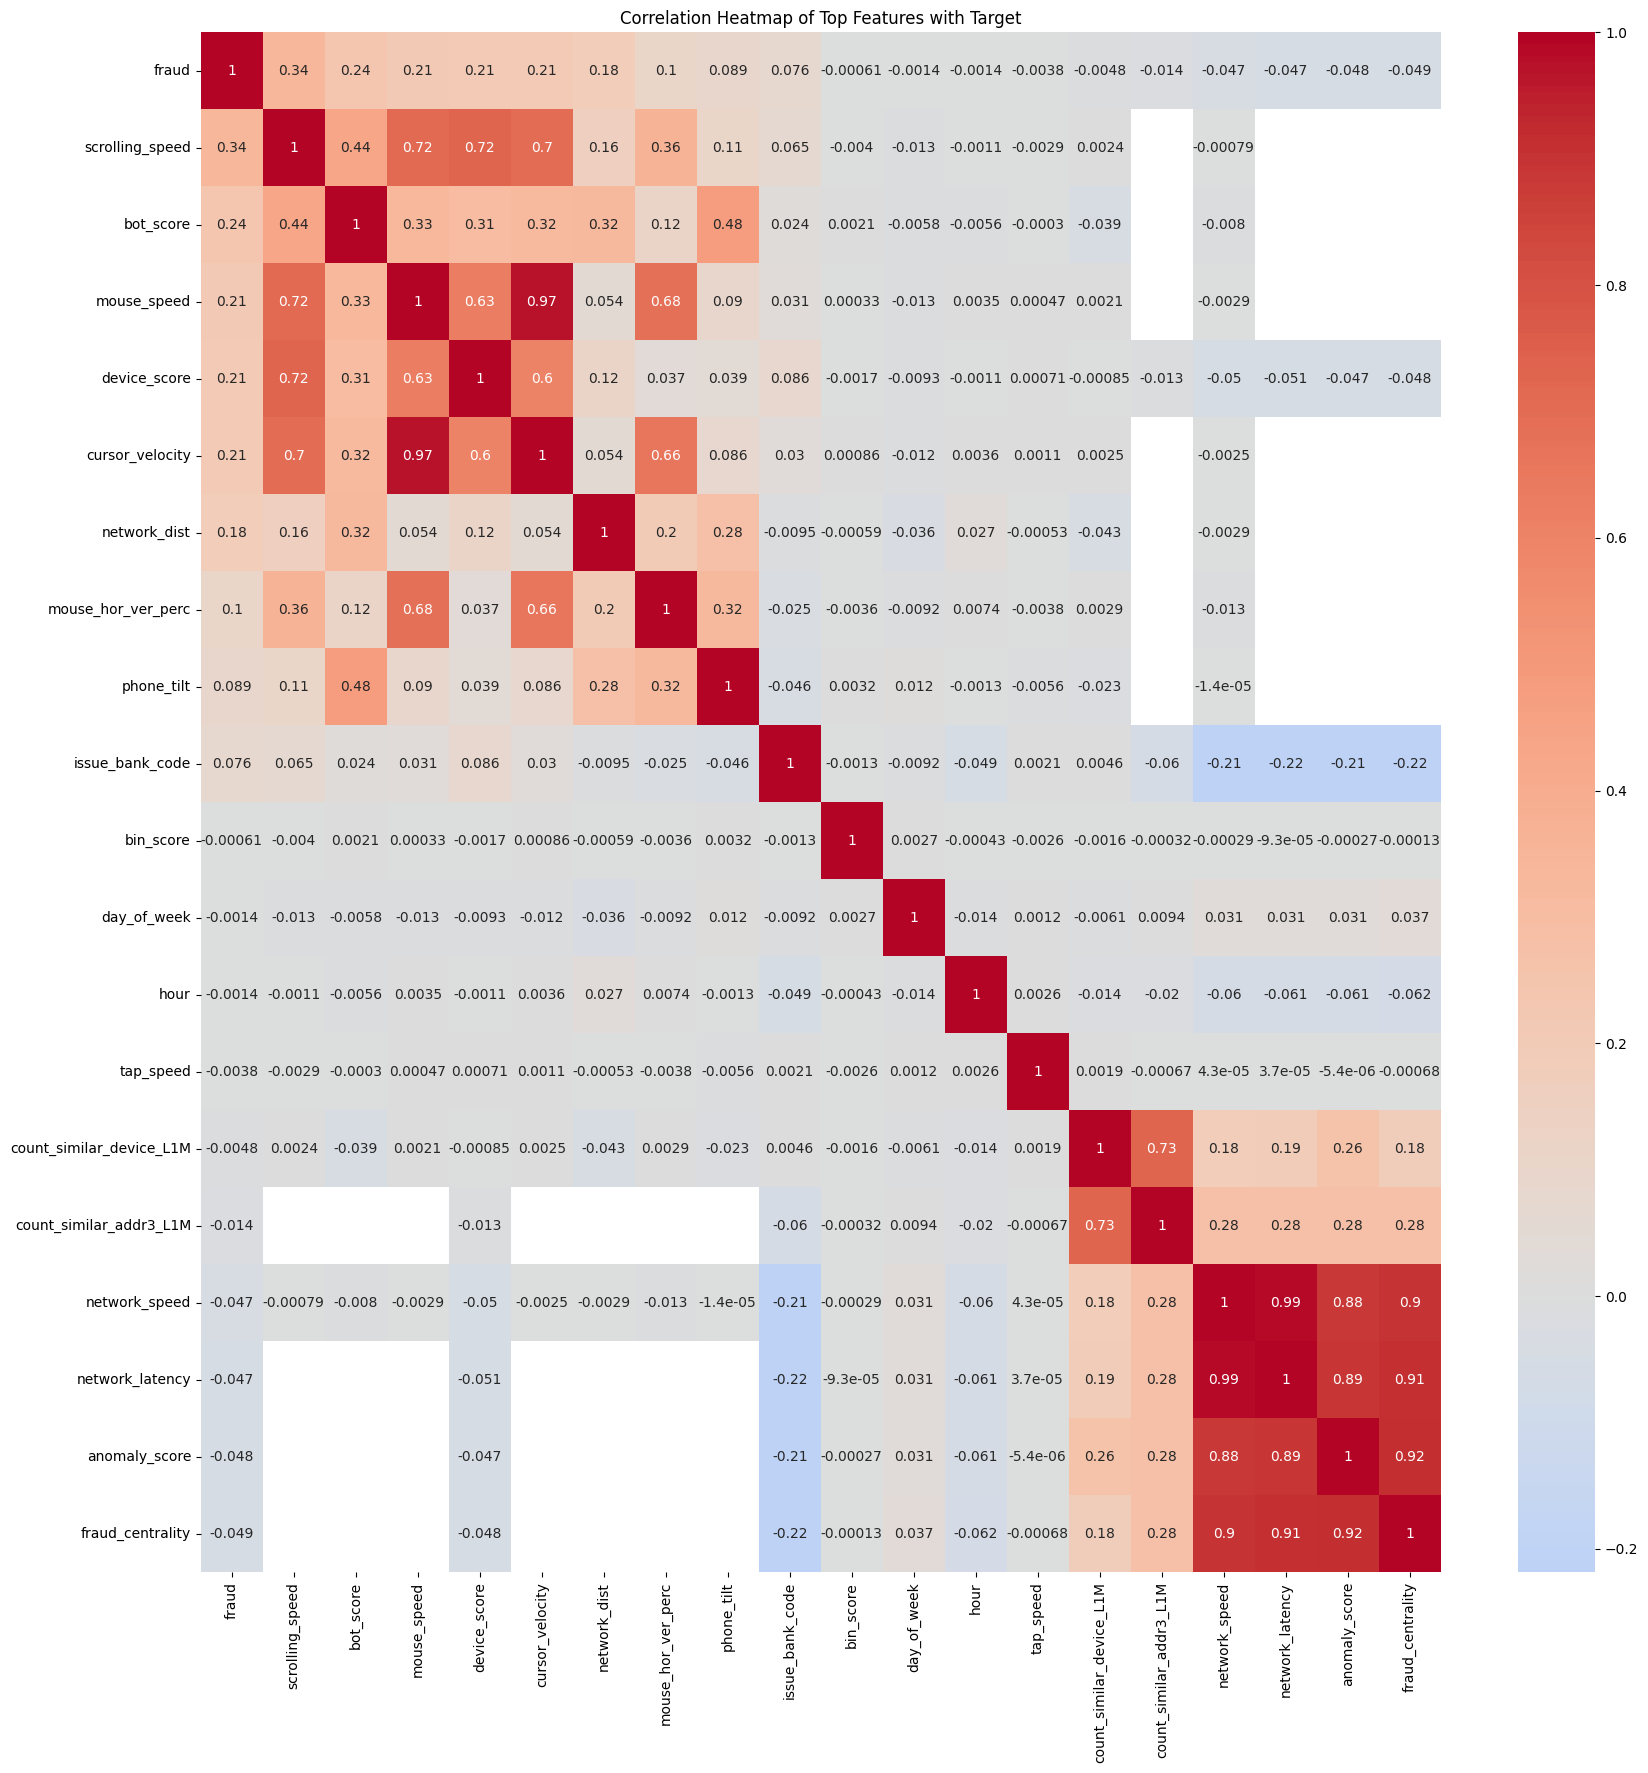

In [14]:
corr_matrix = df.corr(numeric_only=True)
correlations = corr_matrix["fraud"].sort_values(ascending=False)
top_correlations = pd.concat([correlations.head(10), correlations.tail(10)])

plt.figure(figsize=(20, 20))
sns.heatmap(
    df[top_correlations.index].corr(), annot=True, cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap of Top Features with Target")
plt.show()

In [16]:
# higher correlations to drop it
correlation_threshold = 0.9
corr_matrix = df.corr(numeric_only=True).abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
print(to_drop)

['cursor_velocity', 'fraud_centrality', 'anomaly_score', 'count_similar_amount_merchant_L7D', 'count_similar_device_L7D', 'network_speed', 'month']


In [17]:
df.drop(columns = to_drop, inplace = True)
df.shape

(364342, 35)

In [18]:
# get cat and num features
cat_features = list(df.select_dtypes(include=["object"]).columns)
df[cat_features] = df[cat_features].fillna("missing")
num_features = list(df.select_dtypes(include=["int64", "float64"]).columns)
# catdaky misssing valuelari str gechyas 

feature_cols = cat_features + num_features
target = "fraud"
feature_cols.remove(target)

In [22]:
# Imbalance uchin undersample edsek amatly bolyar
X = df[feature_cols]
y = df[target]
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [23]:
X_resampled.head()

,card_scheme,mcc,country_code,card_type,proxy_ip,client_id,amount_usd,transaction_lever,issue_bank_code,network_category,...,count_similar_addr3_L1M,between_centrality,eigen_centrality,network_dist,mouse_hor_ver_perc,phone_tilt,device_score,count_similar_device_L1M,bh_score,addr_dist
payment_id,,,,,,,,,,,,,,,,,,,,,
85726,visa,finance,country_87.0,debit,NotFound,1724763,150.000,1,150.0,166.0,...,0.0,1.0,0.029412,1.0,4.166667,-82.0,0.208333,0.0,0.0,0.0
295242,mastercard,retail,country_87.0,debit,missing,7219093,24.970,2,150.0,NaN,...,1.0,0.0,0.014706,NaN,NaN,NaN,0.208333,0.0,NaN,0.0
31456,visa,retail,country_87.0,debit,missing,689523,209.950,1,150.0,NaN,...,1.0,0.0,0.014706,NaN,NaN,NaN,0.208333,0.0,NaN,0.0
462414,visa,services,country_nan,debit,NotFound,11812604,70.948,3,185.0,225.0,...,0.0,0.0,0.014706,NaN,4.166667,-82.0,0.208333,0.0,0.0,0.0
527969,visa,retail,country_87.0,debit,missing,13804647,204.970,3,150.0,NaN,...,1.0,0.0,0.000000,NaN,NaN,NaN,0.208333,0.0,NaN,0.0


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
params = {
        "iterations": 200,
        "early_stopping_rounds": 10,
        "use_best_model": True,
        "random_seed": 42,
        "learning_rate": 0.1        
    }
model = cb.CatBoostClassifier(**params)

fold =  0
y_preds = []
for train_index, val_index in skf.split(X_resampled, y_resampled):
    fold +=1
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
    model.fit(
            X_train,
            y_train,
            cat_features=cat_features,
            eval_set=[(X_val, y_val)],
            verbose=1000
        )
    y_pred = model.predict(X_val)
    y_preds.append(f1_score(y_val, y_pred))
    print(f'The F1 score:{f1_score(y_val, y_pred)}, for the Fold:{fold}')

average_f1_score = np.mean(y_preds)

print("Average f1 score:", average_f1_score)

0:	learn: 0.6538715	test: 0.6555853	best: 0.6555853 (0)	total: 32.7ms	remaining: 6.51s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4563894832
bestIteration = 92

Shrink model to first 93 iterations.
The F1 score:0.7943760984182777, for the Fold:1
0:	learn: 0.6537575	test: 0.6549726	best: 0.6549726 (0)	total: 30.8ms	remaining: 6.13s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.460462038
bestIteration = 80

Shrink model to first 81 iterations.
The F1 score:0.7654545454545454, for the Fold:2
0:	learn: 0.6533411	test: 0.6549876	best: 0.6549876 (0)	total: 39.3ms	remaining: 7.82s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4652773219
bestIteration = 60

Shrink model to first 61 iterations.
The F1 score:0.7774750227066304, for the Fold:3
0:	learn: 0.6526940	test: 0.6491661	best: 0.6491661 (0)	total: 32.8ms	remaining: 6.52s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4462982716
bestIteration = 73

Sh